This notebook explores FastAI and PyTorch to model an image recognition application. The dataset provided [here](https://www.kaggle.com/agrigorev/clothing-dataset-full) contains 5000 high resolution images of clothes. The model is designed based on this dataset to distinguish among various types of clothing. Unlike the other datasets, this has 2 different variables identifying the piece of clothing - the first variable determines if the image contains a children's clothing and the second variable names the item. After the model has been designed, iPython widgets are used to test the model which can then be deployed onto a server for full functioning end-to-end application.

In [13]:
from fastai.vision.all import *
from fastai.vision.widgets import *


## Data Cleaning

In [14]:
# Import the dataset 
labels = pd.read_csv('/kaggle/input/clothing-dataset-full/images.csv')

In [15]:
labels.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


In [16]:
# Classes and their counts within the dataset
labels['label'].value_counts()

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: label, dtype: int64

Replace 'Not sure' with 'Not_sure'.

In [17]:
labels.loc[labels['label']=='Not sure','label'] = 'Not_sure'

In [18]:
labels['image'] = labels['image'] + '.jpg'

In [19]:
labels['label_cat'] = labels['label'] + ' ' + labels['kids'].astype(str)

In [20]:
label_df = labels[['image', 'label_cat']]

## Preprocessing

Create functions that will be used to open the images and get the categories of the image for the DataBlock.

In [21]:
path = '/kaggle/input/clothing-dataset-full'
def get_x(r): return path+'/images_original/'+r['image'] # create path to open images in the original folder
def get_y(r): return r['label_cat'].split(' ') # split the labels using space as a delimitter

In [22]:
# Create DataBlock
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                  get_x = get_x, get_y = get_y,
                  item_tfms = RandomResizedCrop(128, min_scale=0.35))  # ensure every item is of the same size
dls = dblock.dataloaders(label_df) # collates items from dataset into minibatches

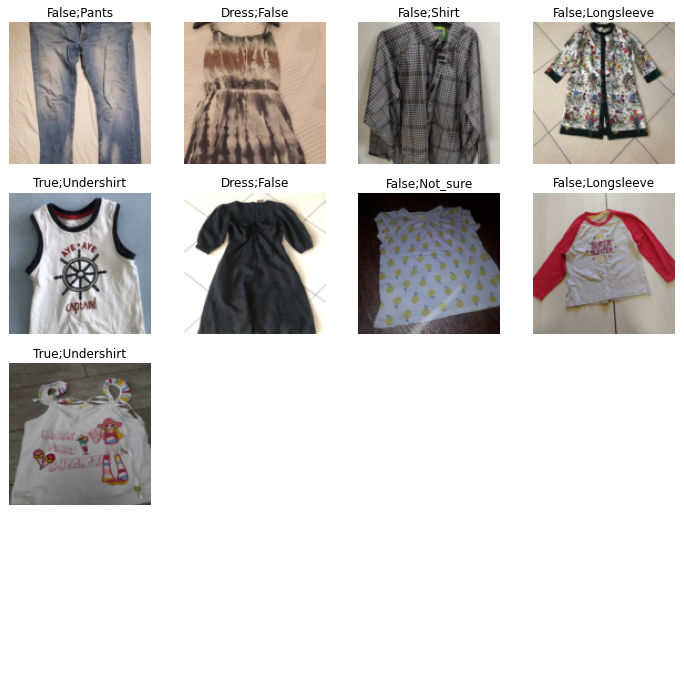

In [23]:
dls.show_batch(nrows=4, ncols=4)

## Create the Learner

In [24]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(5, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.789163,0.321611,0.521254,09:42


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.320323,0.156658,0.914899,10:51
1,0.188161,0.109230,0.957155,10:46
2,0.131767,0.092596,0.964226,10:39
3,0.106039,0.086370,0.963426,10:43
4,0.094644,0.086519,0.965236,10:52


USING 5 EPOCHS AND 96 PERCENT ACCURACY

In [25]:
# Get Predictions and target variables
preds,targs = learn.get_preds()

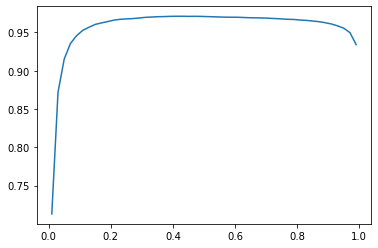

In [26]:
xs = torch.linspace(0.01,0.99,50)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs] # get_preds applies sigmoid activation function
plt.plot(xs,accs);

In [41]:
learn.export(Path("/kaggle/working/export.pkl"))

This model will be stored in the home directory. To import it into you new application use 'load_learner(export.pkl)'


## Test The Model

In [42]:
upload = widgets.FileUpload()
out_image = widgets.Output()
prediction = widgets.Label()
run = widgets.Button(description='Classify')

In [43]:
def on_click_classify(change):
    img = PILImage.create(upload.data[-1])
    out_image.clear_output()
    with out_image: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn.predict(img)
    pred0 = pred[0]
    pred1 = pred[1]
    if pred0=='False':
        prediction.value = f'This is a {pred1} for adults.'
    else:
        prediction.value = f'This is a {pred1} for kids.'
        
run.on_click(on_click_classify)

In [44]:
# Use Virtual Box to encapsulate the iPython widgets
VBox([widgets.Label('Upload a picture of a piece of clothing!'), 
      upload, run, out_image, prediction])